# Part 4.

Ep 1/25:   0%|          | 0/390 [00:15<?, ?it/s]

Epoch [1/25] | D 0.823 | G 1.880


Ep 2/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25] | D 1.128 | G 1.398


Ep 3/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25] | D 1.112 | G 1.392


Ep 4/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25] | D 1.164 | G 1.236


Ep 5/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25] | D 1.096 | G 1.347


Ep 6/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25] | D 1.073 | G 1.343


Ep 7/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25] | D 1.077 | G 1.336


Ep 8/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25] | D 1.122 | G 1.275


Ep 9/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25] | D 1.128 | G 1.251


Ep 10/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25] | D 1.111 | G 1.276


Ep 11/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25] | D 1.086 | G 1.293


Ep 12/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25] | D 1.063 | G 1.351


Ep 13/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25] | D 1.049 | G 1.357


Ep 14/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25] | D 1.032 | G 1.375


Ep 15/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25] | D 1.042 | G 1.374


Ep 16/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25] | D 1.045 | G 1.391


Ep 17/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25] | D 1.042 | G 1.384


Ep 18/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25] | D 1.034 | G 1.396


Ep 19/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25] | D 1.027 | G 1.426


Ep 20/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25] | D 1.015 | G 1.440


Ep 21/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25] | D 0.993 | G 1.460


Ep 22/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25] | D 0.982 | G 1.501


Ep 23/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25] | D 0.964 | G 1.527


Ep 24/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25] | D 0.951 | G 1.552


Ep 25/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25] | D 0.937 | G 1.594


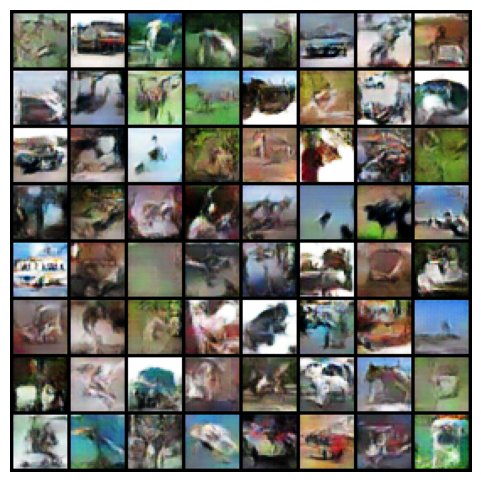

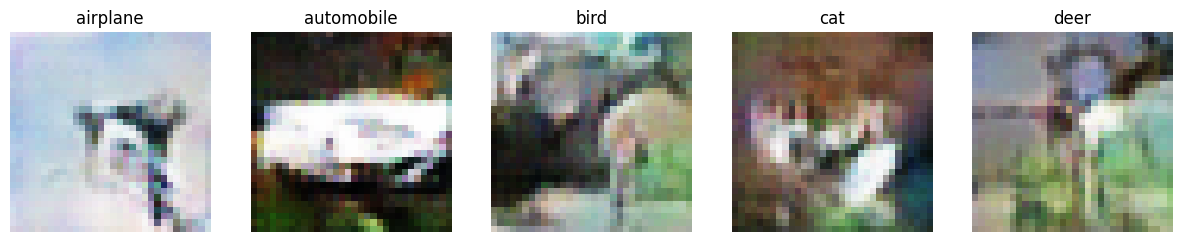

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


saving real:   0%|          | 0/10000 [00:00<?, ?it/s]

IS 3.23 ± 0.08


100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


FID 87.70


In [ ]:
import importlib.util, subprocess, sys, os, shutil, torch, random, math
def need(mod, pkg):
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])
need("torchmetrics", "torchmetrics[image]")
need("torch_fidelity", "torch-fidelity")
need("pytorch_fid", "pytorch-fid")
need("tqdm", "tqdm")

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torchmetrics.image.inception import InceptionScore
from pytorch_fid.fid_score import calculate_fid_given_paths
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt, torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

if not (os.environ.get("COLAB_GPU") and os.environ["COLAB_GPU"]):
    raise SystemExit("Switch Colab to GPU and RESTART the runtime.")

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

# Configuration parameters
cfg = dict(
    batch=128,
    workers=2,
    nz=100,
    ngf=64,
    ndf=64,
    epochs=25,
    lr=2e-4,
    beta1=0.5,
    real_label=0.9,
    fid_samples=10_000,
    num_classes = 10
)
torch.manual_seed(1337); random.seed(1337)

# Initialize weights
def init_w(m):
    if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0, 0.02)

def save_flat(imgs, root, start):
    root.mkdir(parents=True, exist_ok=True)
    for i, img in enumerate(imgs):
        utils.save_image(img, root/f"{start+i:05d}.png", normalize=True, value_range=(-1,1))

tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3,(0.5,)*3)])
ds = datasets.CIFAR10("./data", download=True, transform=tx)
fixed_real, fixed_labels = next(iter(DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)))

dl = DataLoader(ds, batch_size=cfg["batch"], shuffle=True,
                num_workers=cfg["workers"], persistent_workers=True,
                drop_last=True, pin_memory=True)

# Define Generator network
class G(nn.Module):
    def __init__(s):
        super().__init__()
        s.label_emb = nn.Embedding(cfg["num_classes"], cfg["num_classes"])
        s.main = nn.Sequential(
            nn.ConvTranspose2d(cfg["nz"]+cfg["num_classes"], cfg["ngf"]*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*4), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*4, cfg["ngf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*2), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*2, cfg["ngf"], 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"], 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(s, z, labels):
        lb = s.label_emb(labels).view(-1, cfg["num_classes"], 1, 1)
        z = torch.cat([z, lb], dim=1)
        return s.main(z)

# Define Discriminator network
class D(nn.Module):
    def __init__(s):
        super().__init__()
        s.label_emb = nn.Embedding(cfg["num_classes"], cfg["num_classes"])
        s.main = nn.Sequential(
            nn.Conv2d(3+cfg["num_classes"], cfg["ndf"], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"], cfg["ndf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*2, cfg["ndf"]*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(s, x, labels):
        lb = s.label_emb(labels).view(-1, cfg["num_classes"], 1, 1)
        lb = lb.repeat(1,1,x.size(2),x.size(3))
        x = torch.cat([x, lb], dim=1)
        return s.main(x).view(-1)

G, D = G().to(device).apply(init_w), D().to(device).apply(init_w)
crit = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=cfg["lr"], betas=(cfg["beta1"], 0.999))
optD = optim.Adam(D.parameters(), lr=cfg["lr"], betas=(cfg["beta1"], 0.999))
fixed_noise = torch.randn(64, cfg["nz"], 1, 1, device=device)
fixed_label_batch = fixed_labels[:64].to(device)

out = Path("cgan_out"); out.mkdir(exist_ok=True)
fake_dir, real_dir = out/"fake", out/"real"
for p in (fake_dir, real_dir): shutil.rmtree(p, ignore_errors=True)

real_lbl = torch.full((cfg["batch"],), cfg["real_label"], device=device)
fake_lbl = torch.zeros(cfg["batch"], device=device)

G_losses = []
D_losses = []

# Training phase
for ep in range(1, cfg["epochs"]+1):
    D_sum, G_sum = 0, 0
    for real, labels in tqdm(dl, leave=False, desc=f"Ep {ep}/{cfg['epochs']}"):
        bs = real.size(0); real = real.to(device); labels = labels.to(device)

        # Train Discriminator
        D.zero_grad(set_to_none=True)
        z = torch.randn(bs, cfg["nz"], 1, 1, device=device)
        fake = G(z, labels)
        lossD = crit(D(real, labels), real_lbl[:bs]) + crit(D(fake.detach(), labels), fake_lbl[:bs])
        lossD.backward(); optD.step()

        # Train Generator
        G.zero_grad(set_to_none=True)
        lossG = crit(D(fake, labels), real_lbl[:bs])
        lossG.backward(); optG.step()

        D_sum += lossD.item(); G_sum += lossG.item()

    print(f"Epoch [{ep}/25] | D {D_sum/len(dl):.3f} | G {G_sum/len(dl):.3f}")

    G_losses.append(G_sum / len(dl))
    D_losses.append(D_sum / len(dl))

    with torch.no_grad():
        grid_fake = G(fixed_noise, fixed_label_batch).cpu()
        utils.save_image(grid_fake, out/f"fake_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))
        utils.save_image(fixed_real.cpu(), out/f"real_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))

plt.figure(figsize=(6,6)); plt.axis("off")
plt.imshow(utils.make_grid(grid_fake, nrow=8, normalize=True, value_range=(-1,1)).permute(1,2,0)); plt.show()

class_names = ['airplane','automobile','bird','cat','deer']
sample_labels = torch.tensor([0, 1, 2, 3, 4], device=device)
sample_noise = torch.randn(5, cfg["nz"], 1, 1, device=device)

with torch.no_grad():
    samples = G(sample_noise, sample_labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, lbl in enumerate(sample_labels):
    img = (samples[i] * 0.5 + 0.5).permute(1,2,0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(class_names[lbl.item()])
    axes[i].axis("off")
plt.show()

# Evaluate model using IS and FID
metric = InceptionScore(normalize=True).to(device)
saved = 0
with torch.no_grad():
    while saved < cfg["fid_samples"]:
        chunk = min(cfg["batch"], cfg["fid_samples"]-saved)
        labels = torch.randint(0, cfg["num_classes"], (chunk,), device=device)
        imgs = G(torch.randn(chunk, cfg["nz"], 1, 1, device=device), labels).cpu()
        save_flat(imgs, fake_dir, saved)
        metric.update(imgs.to(device)); saved += imgs.size(0)
for i in tqdm(range(cfg["fid_samples"]), desc="saving real"):
    save_flat(ds[i][0].unsqueeze(0), real_dir, i)

# Report final scores
is_mean, is_std = metric.compute()
print(f"IS {is_mean:.2f} ± {is_std:.2f}")
fid = calculate_fid_given_paths([str(real_dir), str(fake_dir)], batch_size=128, device=device, dims=2048)
print(f"FID {fid:.2f}")

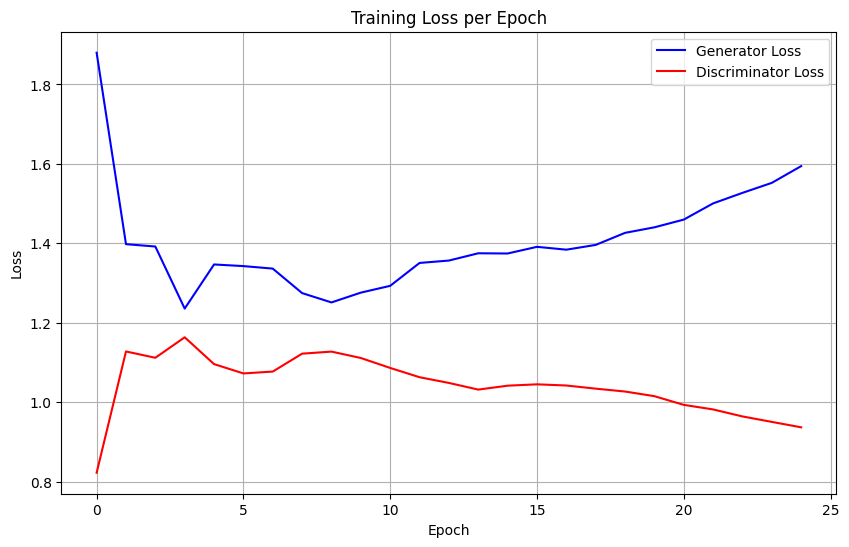

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(G_losses, label="Generator Loss", color="blue")
plt.plot(D_losses, label="Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()